In [1]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import os
import matplotlib.pyplot as plt
import cortex
import seaborn as sns
from os.path import join
from collections import defaultdict
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib
import dvu
from copy import deepcopy
import sys
sys.path.append('../notebooks')
from tqdm import tqdm
from sasc.config import FMRI_DIR, STORIES_DIR, RESULTS_DIR, CACHE_DIR, RESULTS_DIR, cache_ngrams_dir, regions_idxs_dir
from neuro.config import repo_dir, PROCESSED_DIR
from neuro.features.qa_questions import get_questions, get_merged_questions_v3_boostexamples
import sasc.viz
from sasc import config
VOX_COUNTS = {
    'S02': 94251,
    'S03': 95556,
}

### Load avg-response flatmaps

In [79]:
# S03
subject = 'S03'
gemv_flatmaps_roi_custom1 = joblib.load(join(
    RESULTS_DIR, "processed", "flatmaps_all", 'UTS03', 'roi_pilot7', 'resps_avg_dict_pilot7.pkl'))
gemv_flatmaps_roi_custom2 = joblib.load(join(
    RESULTS_DIR, "processed", "flatmaps_all", 'UTS03', 'roi_pilot8', 'resps_avg_dict_pilot8.pkl'))
# gemv_flatmaps_dict = gemv_flatmaps_default | gemv_flatmaps_roi_custom1 | gemv_flatmaps_roi_custom2
gemv_flatmaps_dict = gemv_flatmaps_roi_custom1 | gemv_flatmaps_roi_custom2

# normalize flatmaps
normalize_flatmaps = True
if normalize_flatmaps:
    for k, v in gemv_flatmaps_dict.items():
        flatmap_unnormalized = gemv_flatmaps_dict[k]
        gemv_flatmaps_dict[k] = (
            flatmap_unnormalized - np.nanmean(flatmap_unnormalized)) / np.nanstd(flatmap_unnormalized)

### Group regions to analyze into dictionary of voxel indexes
rois_dict is a dictionary with keys as region names and np arrays of voxel masks as values

In [80]:
def load_known_rois(subject):
    nonzero_entries_dict = joblib.load(
        join(regions_idxs_dir, f'rois_{subject}.jbl'))
    rois_dict = {}
    for k, v in nonzero_entries_dict.items():
        mask = np.zeros(VOX_COUNTS[subject])
        mask[v] = 1
        rois_dict[k] = deepcopy(mask)
    if subject == 'S03':
        rois_dict['OPA'] = rois_dict['TOS']
    return rois_dict


rois_dict = load_known_rois(subject)

### Visualize averages over different regions

In [81]:
ROI_EXPLANATIONS = {
    'EBA': 'Body parts',
    'IPS': 'Descriptive elements of scenes or objects',
    'OFA': 'Conversational transitions',
    'OPA': 'Direction and location descriptions',
    'OPA_only': 'Self-reflection and growth',
    'PPA': 'Scenes and settings',
    'PPA_only': 'Garbage, food, and household items',
    'RSC': 'Travel and location names',
    'RSC_only': 'Location names',
    'sPMv': 'Dialogue and responses',
}
gemv_flatmaps_dict_filt = {
    k[0]: v for k, v in gemv_flatmaps_dict.items() if k[0] in ROI_EXPLANATIONS.values()}
assert len(gemv_flatmaps_dict_filt) == len(ROI_EXPLANATIONS)
rois_dict_filt = {k: v for k, v in rois_dict.items() if k in ROI_EXPLANATIONS}

In [82]:
avg_defaultdict = defaultdict(list)
for roi_idx, roi in rois_dict_filt.items():
    for explanation in gemv_flatmaps_dict_filt.keys():
        avg_defaultdict[roi_idx].append(
            np.mean(gemv_flatmaps_dict_filt[explanation][roi > 0]))
        # corrs_defaultdict[roi_idx].append(
        # np.corrcoef(roi, gemv_flatmaps_dict[explanation])[0, 1])

In [83]:
df = pd.DataFrame(avg_defaultdict, index=gemv_flatmaps_dict_filt.keys())
df['AVG'] = df.mean(axis=1)
for k in ['RSC', 'PPA', 'OPA']:
    df[k + '_only'] = df[k]

# reindex cols by ROI_EXPLANATIONS keys
df = df[list(ROI_EXPLANATIONS.keys())]

# reindex rows by ROI_EXPLANATIONS values
df = df.reindex(list(ROI_EXPLANATIONS.values()))

# df = df.round(3).sort_values('AVG', ascending=False)
# display pandas formatting with redblue colormap centered at 0 rounded to 3 decimal places
vabs = max(abs(df.values.min()), abs(df.values.max()))

# visualize and outline diagonal elements of matrix
(
    df.style
    .background_gradient(cmap='coolwarm', axis=None, vmax=vabs, vmin=-vabs)
    .format("{:.3f}").set_caption(
        'Average GEM-V driving response averaged over ROI'
    )
)

,EBA,IPS,OFA,OPA,OPA_only,PPA,PPA_only,RSC,RSC_only,sPMv
Body parts,0.314,0.048,-0.794,-0.562,-0.562,-0.272,-0.272,-0.549,-0.549,-0.308
Descriptive elements of scenes or objects,-0.170,-0.605,-0.720,-0.220,-0.220,0.058,0.058,-0.032,-0.032,-0.780
Conversational transitions,-0.348,0.034,0.231,0.409,0.409,0.297,0.297,-0.078,-0.078,-0.246
Direction and location descriptions,-0.378,0.179,-0.555,0.104,0.104,0.172,0.172,0.491,0.491,-0.411
Self-reflection and growth,0.105,0.631,-0.041,0.431,0.431,-0.155,-0.155,-0.079,-0.079,0.222
Scenes and settings,-0.305,0.064,0.187,0.086,0.086,0.034,0.034,0.318,0.318,0.264
"Garbage, food, and household items",0.009,-0.095,0.088,0.294,0.294,0.833,0.833,0.568,0.568,-0.063
Travel and location names,-0.365,0.394,-0.707,0.083,0.083,0.053,0.053,0.034,0.034,-0.323
Location names,-0.501,-0.668,-0.777,-0.254,-0.254,0.231,0.231,0.495,0.495,-0.302
Dialogue and responses,0.069,0.313,0.372,0.049,0.049,0.029,0.029,0.178,0.178,0.516


Text(0, 0.5, 'Explanation')

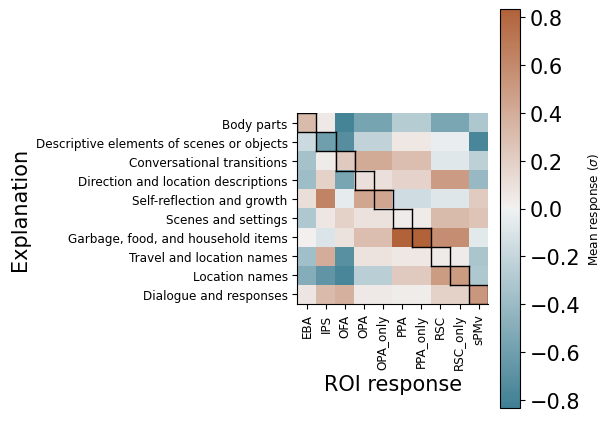

In [84]:
s = 'xx-small'
sasc.viz.outline_diagonal(df.shape, color='black', lw=1, block_size=1)
plt.yticks(labels=df.index, ticks=np.arange(df.shape[0]), fontsize=s)
plt.xticks(labels=df.columns, ticks=np.arange(
    df.shape[1]), fontsize=s, rotation=90)

# display as seaborn heatmap
sasc.viz.imshow_diverging(
    df, clab="Mean response ($\sigma$)", clab_size='xx-small')
plt.xlabel('ROI response')
plt.ylabel('Explanation')

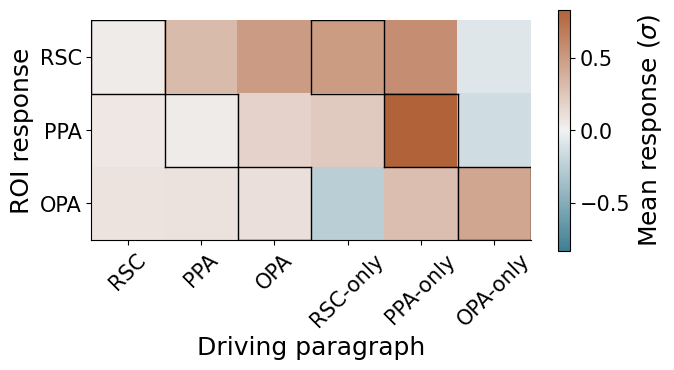

In [87]:
plt.figure(figsize=(7, 3.9))

df_filt = df[['RSC', 'PPA', 'OPA']]
XLABS = ['RSC', 'PPA', 'OPA',  'RSC_only', 'PPA_only', 'OPA_only']
df_filt = df_filt.loc[[ROI_EXPLANATIONS[k] for k in XLABS]]
df_filt = df_filt.T

s = 'medium'
dvu.outline_diagonal(df_filt.shape, color='black',
                     lw=1, block_size=1, roffset=0)
dvu.outline_diagonal(df_filt.shape, color='black',
                     lw=1, block_size=1, roffset=3)
# sasc.viz.outline_diagonal(df_filt.shape, color='black', lw=1, block_size=1)
plt.yticks(labels=df_filt.index, ticks=np.arange(df_filt.shape[0]), fontsize=s)
plt.xticks(labels=[x.replace('_', '-') for x in XLABS], ticks=np.arange(
    df_filt.shape[1]), fontsize=s, rotation=45)

# display as seaborn heatmap
sasc.viz.imshow_diverging(
    df_filt, clab="Mean response ($\sigma$)", clab_size='large')
plt.xlabel('Driving paragraph', fontsize='large')
plt.ylabel('ROI response', fontsize='large')
plt.savefig(join(config.RESULTS_DIR, 'figs/main',
            'S03' + '_roi_heatmap.pdf'), bbox_inches='tight')
plt.show()

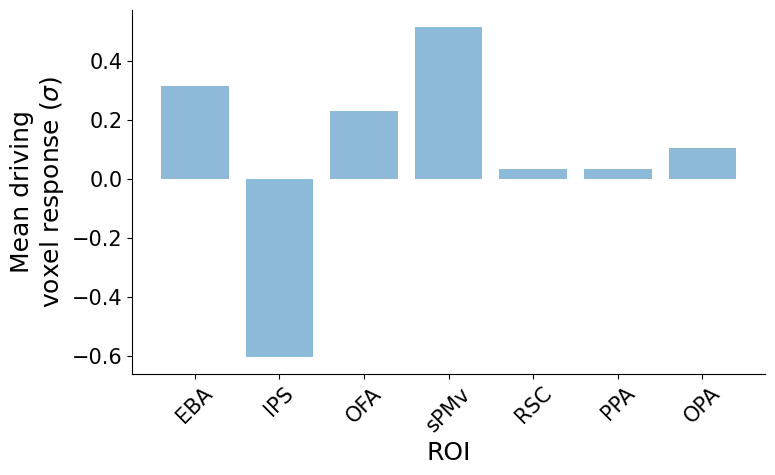

In [86]:
# plot diagonal as barplot
plt.figure(figsize=(8, 5))
XLABS = ['EBA', 'IPS', 'OFA', 'sPMv', 'RSC', 'PPA', 'OPA']
df_bar = df[XLABS]
df_bar = df_bar.loc[[ROI_EXPLANATIONS[k] for k in XLABS]]
mat = df_bar.values
# normalize mat rows
# mat = (mat - np.nanmean(mat, axis=1)[:, None]) / np.nanstd(mat, axis=1)[:, None]
vals = mat.diagonal()
plt.bar(range(len(vals)), vals, color='C0', alpha=0.5)
# add xlabel
plt.xticks(range(len(vals)), df_bar.columns, rotation=45)
plt.xlabel('ROI', fontsize='large')
plt.ylabel('Mean driving\nvoxel response ($\sigma$)', fontsize='large')
plt.tight_layout()
plt.show()

In [77]:
df_bar

,EBA,IPS,OFA,sPMv,RSC,PPA,OPA
Body parts,-0.028247,-0.106053,-0.352686,-0.210173,-0.280967,-0.199743,-0.284684
Descriptive elements of scenes or objects,-0.183020,-0.353019,-0.398062,-0.421682,-0.129128,-0.093926,-0.202768
Conversational transitions,-0.018463,0.061618,0.102888,0.003063,0.038137,0.116631,0.140016
Direction and location descriptions,-0.115187,0.033146,-0.162367,-0.124218,0.116291,0.031372,0.013239
Self-reflection and growth,-0.005662,0.147149,-0.047898,0.028335,-0.058898,-0.081149,0.089045
Scenes and settings,-0.006392,0.090153,0.122422,0.142453,0.156793,0.082483,0.095993
"Garbage, food, and household items",0.058469,0.036449,0.075051,0.043256,0.176458,0.232479,0.118689
Travel and location names,-0.045291,0.133711,-0.125707,-0.035346,0.048822,0.053329,0.060346
Location names,-0.272560,-0.325698,-0.360466,-0.209423,0.044078,-0.039986,-0.194288
Dialogue and responses,0.112116,0.187327,0.205404,0.249922,0.145572,0.099575,0.105817


In [ ]:
vals = []
for k, v in ROI_EXPLANATIONS:
    
    

In [ ]:
# sasc.viz._save_flatmap(
#     gemv_flatmaps_dict[('relationships between people', 'qa')], subject, fname_save=f'gemv_flatmaps/relationships_{subject}.png')